# Prerequisites

In [1]:
!pip3 install --upgrade pip
!pip3 install -r requirements.txt

In [2]:
!pip3 install pycaret


In [3]:
# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

# Loading custom helpers

In [4]:
import requests  # Used for making HTTP requests to fetch online resources.

# URL of the raw file in the GitHub Gist
url = 'https://gist.githubusercontent.com/JMartinArocha/79e6f5c94ab6a8d3f0b2f57296395e76/raw/3d60d10fb336eb870cb03535929502bc8234abc9/ml_utilities.py'

# Fetching the content of the file
r = requests.get(url)

# Writing the content to a local file to ensure the utility script is available for import
with open('ml_utilities.py', 'w') as f:
    f.write(r.text)

# Importing the ml_utilities script after downloading it
import ml_utilities

# Loading datasets 

In [5]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

url_df_train = 'https://raw.githubusercontent.com/JMartinArocha/EarthquakeDamageModels/data/train_values.csv'
url_df_labels = 'https://raw.githubusercontent.com/JMartinArocha/EarthquakeDamageModels/data/train_labels.csv'
url_df_test = 'https://raw.githubusercontent.com/JMartinArocha/EarthquakeDamageModels/data/test_values.csv'

# df = pd.read_csv(url_df_train, index_col='building_id')
# df_labels = pd.read_csv(url_df_labels, index_col='building_id')
# df_test = pd.read_csv(url_df_test, index_col='building_id')

df = pd.read_csv('data/train_values.csv', index_col='building_id')
df_labels = pd.read_csv('data/train_labels.csv', index_col='building_id')
df_test = pd.read_csv('data/train_labels.csv', index_col='building_id')

ml_utilities.df_look(df)
ml_utilities.df_look(df_labels)

First few rows of the DataFrame:
             geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906                    6             487           12198   
28830                     8             900            2812   
94947                    21             363            8973   
590882                   22             418           10694   
201944                   11             131            1488   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
802906                         2   30                6                  5   
28830                          2   10                8                  7   
94947                          2   10                5                  5   
590882                         2   10                6                  5   
201944                         3   30                8         

# Data clean and normalization

<Axes: title={'center': 'Number of Buildings with Each Damage Grade'}, xlabel='damage_grade'>

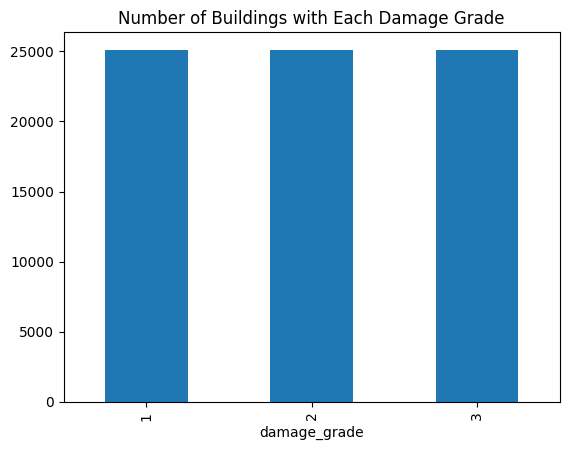

In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# List of columns to be encoded
categorical_columns = ['land_surface_condition', 'foundation_type', 'roof_type', 
                       'ground_floor_type', 'other_floor_type', 'position', 
                       'plan_configuration', 'legal_ownership_status']

# Apply the label encoder to each categorical column using a loop
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Fill missing values with forward fill method to ensure continuity and avoid NaN values that could affect the analysis
df.fillna(method='ffill', inplace=True)

# Normalize the datasets using a custom utility function. This standardizes the scale of the features, improving model performance.
df = ml_utilities.normalize_dataset(df, MinMaxScaler((1,3)))

# Merge to facilitate direct analysis and modeling
df['damage_grade'] = df_labels.damage_grade

df['foundation_type'] = df['foundation_type'].astype(int)
df['area_percentage'] = df['area_percentage'].astype(int)
df['height_percentage'] = df['height_percentage'].astype(int)
df['count_floors_pre_eq'] = df['count_floors_pre_eq'].astype(int)
df['land_surface_condition'] = df['land_surface_condition'].astype(int)
df['damage_grade'] = df['damage_grade'].astype(int)

min_size = df['damage_grade'].value_counts().min()  # Encuentra el tamaño de la clase más pequeña
df = pd.concat([df[df['damage_grade'] == i].sample(min_size, random_state=42) for i in df['damage_grade'].unique()])
(df.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

# Graphical Methods and Feature Selection

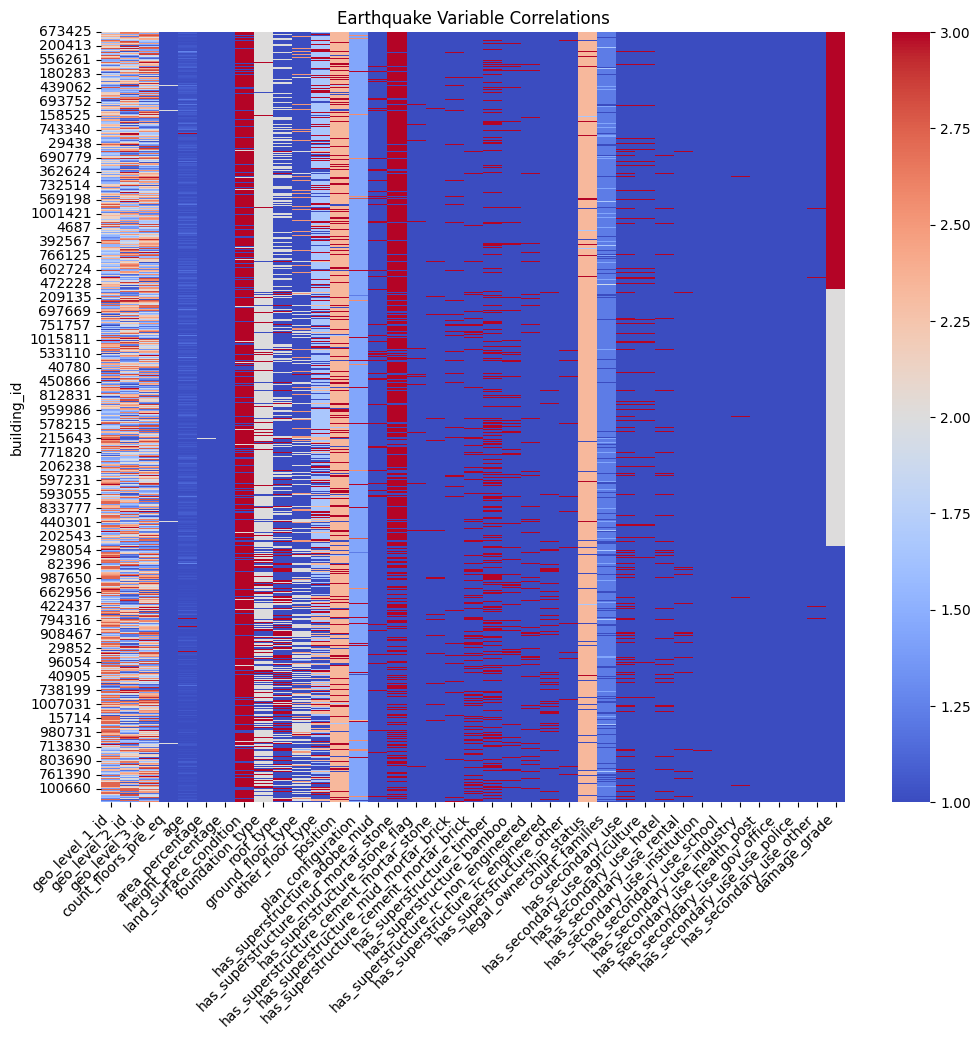

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
# Ensure 'df' is your DataFrame
plt.figure(figsize=(12, 10))
sns.heatmap(df, annot=False, cmap='coolwarm')  # Display correlations with annotations in a heatmap
plt.title('Earthquake Variable Correlations')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [8]:
# Import necessary libraries for feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Separate the features and the target variable
X = df.drop(columns=['damage_grade'])  
y = df['damage_grade'] 

# Initialize SelectKBest with f_classif, the ANOVA F-value function, choosing top 'k' features
selector = SelectKBest(f_classif, k=5)  # 'k=5' can be adjusted based on desired number of features

# Fit the model and transform the dataset to select the top 'k' features
X_new = selector.fit_transform(X, y)

# Get the names of the selected features
KBest_selected_features = X.columns[selector.get_support()]

# Print the names of the selected features
print(KBest_selected_features)

Index(['roof_type', 'ground_floor_type', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_cement_mortar_brick',
       'has_superstructure_rc_engineered'],
      dtype='object')


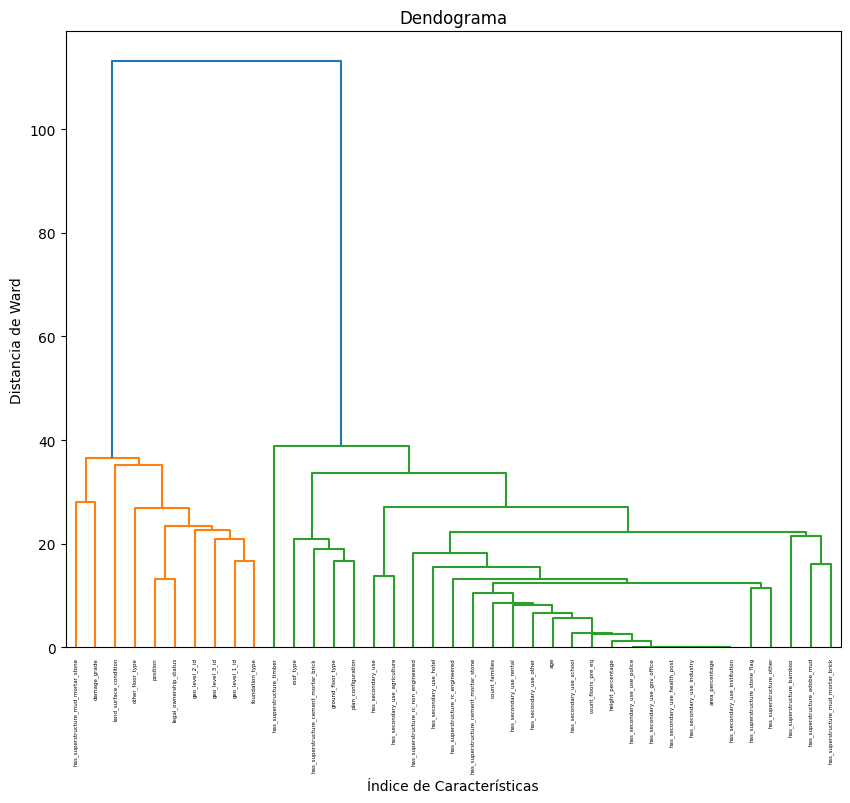

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Reduce the size of the dataset to avoid crash
sample_df = df.sample(frac=0.01).transpose()
labels = sample_df.index.astype(str)
# Calculate linkage matrix
Z = linkage(sample_df, 'ward')
# Create dendogram
plt.figure(figsize=(10, 8))
dendrogram(
    Z,
    labels=labels,  
    leaf_rotation=90,
    leaf_font_size=4,
)
plt.title('Dendograma')
plt.xlabel('Índice de Características')
plt.ylabel('Distancia de Ward')
plt.show()


# Data spliting

In [10]:
from sklearn.model_selection import train_test_split

# Selecting the features for modeling
features = ['foundation_type', 'area_percentage', 'height_percentage',
            'count_floors_pre_eq', 'land_surface_condition', 'damage_grade']

# Sampling 10% of the data to reduce computational load, with a fixed random state for reproducibility
df = df[features].sample(frac=0.1, random_state=42) 

# Separating the dataset into features (X) and the target variable (y)
X = df.drop(columns=['damage_grade'])  # Exclude the target variable from features
y = df['damage_grade']  # Target variable

# Splitting the dataset into training and testing sets, with 20% of the data reserved for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further splitting the training set into training and validation sets, with 25% of the training data reserved for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# Automated Model Comparison with LazyPredict

In [11]:
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# For classification:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print("Classification Models Performance:")
print(models)

# For regression:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print("Regression Models Performance:")
print(models)



 90%|████████▉ | 26/29 [00:02<00:00,  9.92it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11
[LightGBM] [Info] Number of data points in the train set: 4521, number of used features: 3
[LightGBM] [Info] Start training from score -1.111300
[LightGBM] [Info] Start training from score -1.099940
[LightGBM] [Info] Start training from score -1.084774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

100%|██████████| 29/29 [00:03<00:00,  9.44it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 98%|█████████▊| 41/42 [00:07<00:00,  7.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11
[LightGBM] [Info] Number of data points in the train set: 4521, number of used features: 3
[LightGBM] [Info] Start training from score 2.008848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████| 42/42 [00:07<00:00,  5.74it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

# Automated Model comparison with PyCaret


In [12]:
# init setup
from pycaret.classification import *
clf1 = setup(data = df, target = 'damage_grade')
best = compare_models()

,Description,Value
0,Session id,2818
1,Target,damage_grade
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(7537, 6)"
5,Transformed data shape,"(7537, 6)"
6,Transformed train set shape,"(5275, 6)"
7,Transformed test set shape,"(2262, 6)"
8,Numeric features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4633,0.0000,0.4633,0.5519,0.3715,0.1954,0.2899,0.4420
dt,Decision Tree Classifier,0.4629,0.0000,0.4629,0.5333,0.3706,0.1949,0.2887,0.0040
rf,Random Forest Classifier,0.4629,0.0000,0.4629,0.5508,0.3714,0.1949,0.2884,0.0260
et,Extra Trees Classifier,0.4628,0.0000,0.4628,0.5332,0.3705,0.1946,0.2881,0.0180
ada,Ada Boost Classifier,0.4626,0.0000,0.4626,0.4347,0.3664,0.1943,0.2914,0.0130
gbc,Gradient Boosting Classifier,0.4624,0.0000,0.4624,0.5331,0.3702,0.1940,0.2872,0.0320
xgboost,Extreme Gradient Boosting,0.4624,0.0000,0.4624,0.5497,0.3708,0.1940,0.2870,0.0140
nb,Naive Bayes,0.4620,0.0000,0.4620,0.5236,0.3699,0.1934,0.2872,0.0040
knn,K Neighbors Classifier,0.4298,0.0000,0.4298,0.4160,0.3607,0.1436,0.1817,0.0090
lda,Linear Discriminant Analysis,0.4135,0.0000,0.4135,0.5394,0.3745,0.1165,0.1534,0.0030


# Training - CrossValidation, RandomSearch y GridSearch

In [13]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from scipy.stats import uniform

# Configuration for the AdaBoost Regressor
model = AdaBoostRegressor()

# Define parameters for Randomized Search
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': uniform(0.01, 1)  # Continuously distributed parameters for the learning rate
}

# Perform Random Search
random_search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Define parameters for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5, 1]
}

# Perform Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Evaluate using cross-validation
cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)

# Print the best parameters and cross-validation scores
print("Best parameters from RandomSearch:", random_search.best_params_)
print("Best parameters from GridSearch:", grid_search.best_params_)
print("Cross-validation scores:", cross_val_scores)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters from RandomSearch: {'learning_rate': 0.03058449429580245, 'n_estimators': 100}
Best parameters from GridSearch: {'learning_rate': 0.01, 'n_estimators': 50}
Cross-validation scores: [0.16047188 0.18514466 0.14178169 0.21708724 0.17679913]


Micro-averaged F1 score: 0.4442970822281167
Mean Squared Error on Validation Set: 0.5736074270557029
R^2 Score on Validation Set: 0.13326422942497584


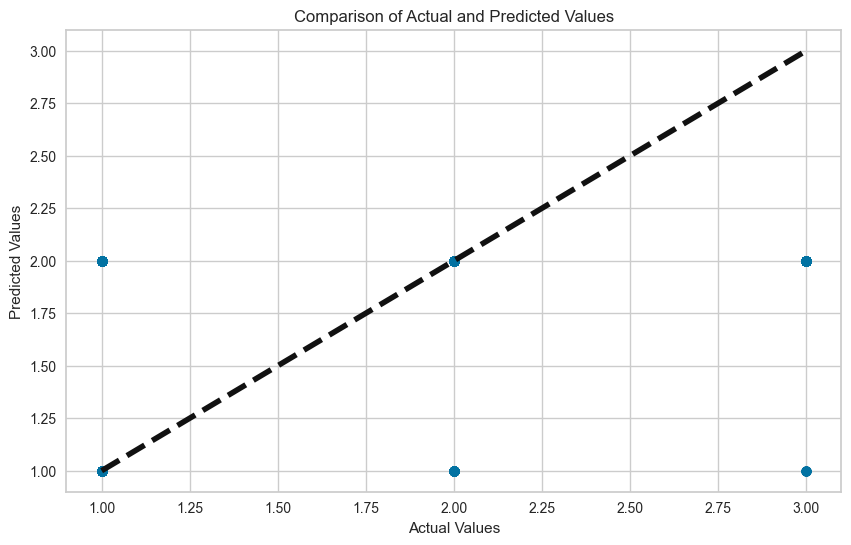

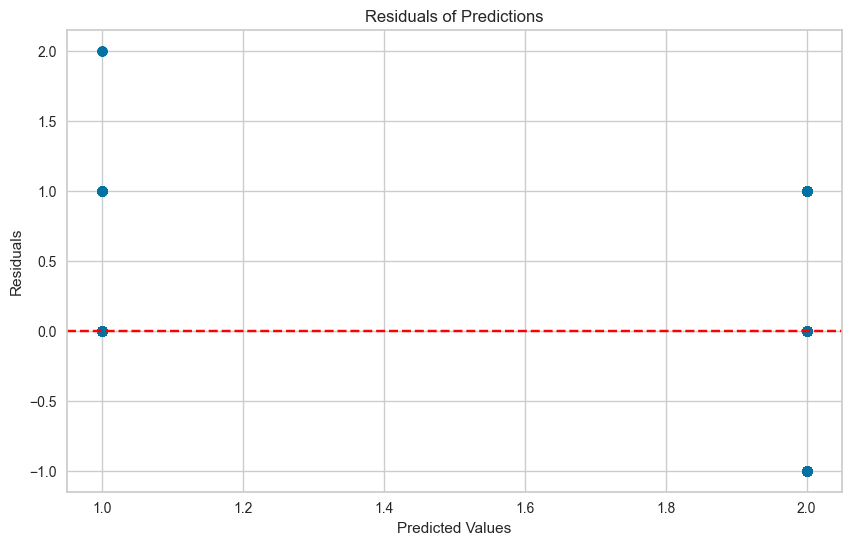

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Predict validation set
y_pred_val = grid_search.best_estimator_.predict(X_val)

# Round predictions for classification metrics
y_pred_val_rounded = np.round(y_pred_val).astype(int)

# Calculate metrics
mse = mean_squared_error(y_val, y_pred_val_rounded)
r2 = r2_score(y_val, y_pred_val_rounded)
f1 = f1_score(y_val, y_pred_val_rounded, average='micro')

# Output metrics
print("Micro-averaged F1 score:", f1)
print("Mean Squared Error on Validation Set:", mse)
print("R^2 Score on Validation Set:", r2)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val_rounded, alpha=0.5)
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
plt.show()

# Plotting the residuals
residuals = y_val - y_pred_val_rounded
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_val_rounded, residuals, alpha=0.5)
plt.title('Residuals of Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()